# 6. 나를 찾아줘 - Class Activation Map 만들기

## 6-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기


---

#### CAM(class activation map)
     클래스에 대한 활성화 정도를 나타낸 지도
     cnn 네트워크 뒤에 GAP(Global Average Pooling) 과 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성됨 

- CAM, GRAD-CAM 두 가지를 구현해보자
- grad-cam은 모델 구조에 제약이 없어서 cam모델을 먼저 만들고 이걸 활용해서 grad cam구현
- 우리 모델은 classification을 수행해야함
- 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치정보가 기록된 데이터가 함께 있어야 한다

--- 
#### Dataset
     Tensorflow Datasets, stanford_dogs 데이터셋
     120종 개 사진 분류 문제 데이터셋
     라벨이 위치 정보인 바운딩박스(bounding box)정보를 포함한다
     train 120000장
     test 8580장


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXNT2JM/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXNT2JM/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


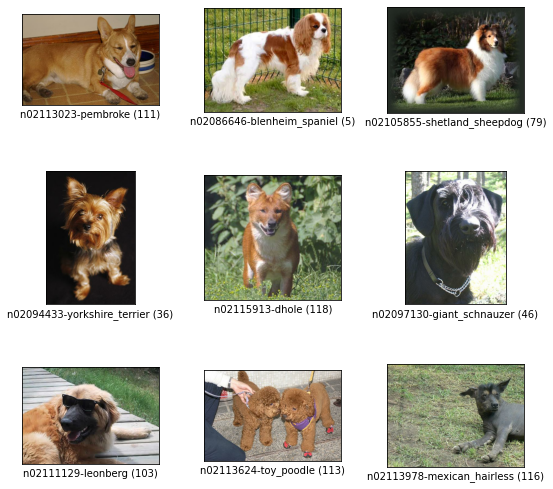

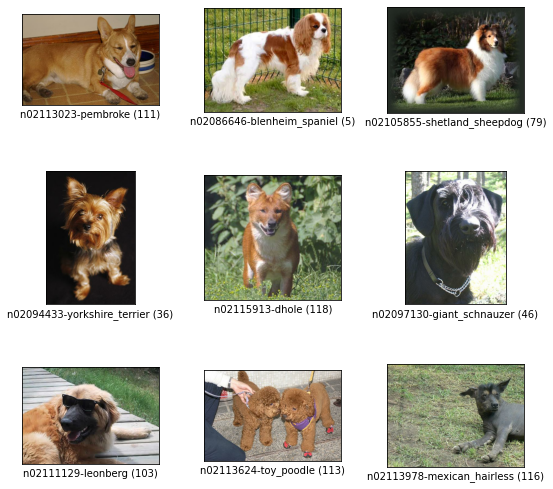

In [ ]:
# 각 이미지의 클래스와 인덱스 확인
tfds.show_examples(ds_train, ds_info)

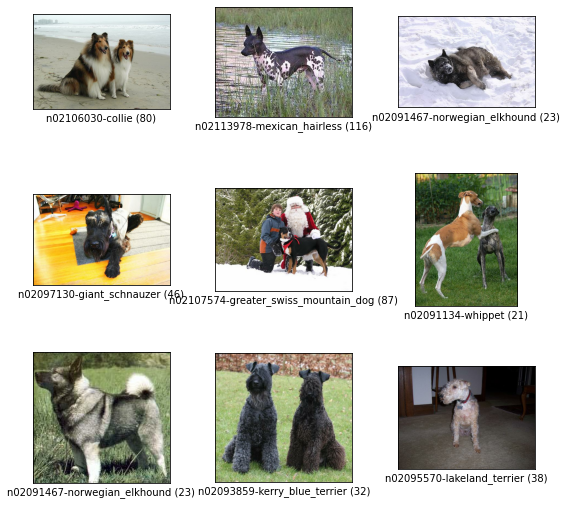

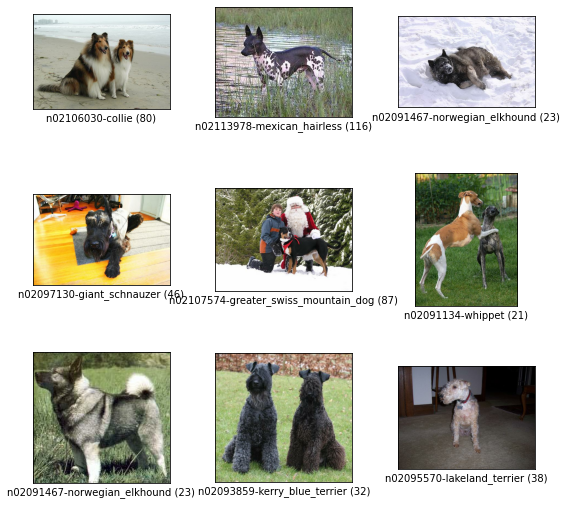

In [ ]:
tfds.show_examples(ds_test, ds_info)

## 6-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보
--- 
- 원본 이미지 위에 물체의 위치정보를 시각화하자
- 데이터셋의 메타 정보인 df_info 를 조회해서 features 구성 확인

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- `bbox` : 물체의 위치를 사각형으로 표기하는 방법
<br>

- 'xywh' --> 바운딩박스 중심점을 x, y로 표시하고 사각형의 너비와 높이를 표기하는 방법
    - ex. (x_center, y_center, width, height)
    - x,y가 중심점이 아니라 좌측 상단의 점을 가리킬 수 있다
- 'minmax' --> 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법
    - ex. (x_min, x_max, y_min, y_max)
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적임

## 6-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
---
- 미리 이미지넷 데이터에 훈련된 ResNet50을 기반으로 모델 생성
- pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM모델을 만들자
- 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fc layer

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


- 마지막 fc layer 대신 GAP를 사용하기 위해 매개변수 `pooling`에 `avg`를 전달함

In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

- conv5_block3_out의 output이 feature map
- feature map에 gap를 해서 feature의 크기를 줄인다
- 줄어든 feature 전체에 dense layer를 붙여서 classification을 수행한다

## 6-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기
---
- `normalize_and_resize_img()` normalize + resizing을 포함한 간단한 전처리 수행
- `apply_normalize_on_dataset()` 배치 구성
- input에 bbox정보는 cam모델 학습에는 필요없으므로 제외한다
- cam 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방법이다

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


- model compile + train 2에폭만! (뒤에서는 미리 학습된 가중치를 불러와서 모델에 적용할 예정)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 117s 127ms/step - loss: 2.1969 - accuracy: 0.4493 - val_loss: 3.0070 - val_accuracy: 0.2515
Epoch 2/2
750/750 [==============================] - 95s 126ms/step - loss: 0.7148 - accuracy: 0.8012 - val_loss: 1.1716 - val_accuracy: 0.6514


In [ ]:
# 학습시킨 가중치 저장
import os

os.environ['HOME'] = '/content/drive/MyDrive'

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 6-6. CAM
---
- 학습된 모델을 활용해 CAM 생성

In [ ]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWVKWET/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWVKWET/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


- cam 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()`함수로 한장씩 뽑을 수 있도록 한다

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


67


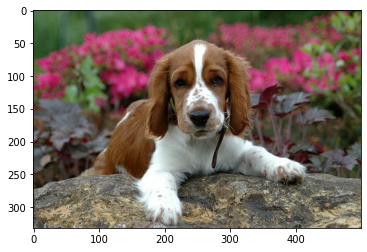

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 미리 준비된 학습한 모델 불러오기
import os

os.environ['HOME'] = '/content/drive/MyDrive'

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


- cam을 생성하기 위해서는 1. 특성맵, 2. 클래스별 확률을 얻기 윟한 소프트맥스 레이어의 가중치, 3. 원하는 클래스의 출력값이 필요하다.
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 한다
- 그래서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 함

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


- 작성한 함수를 실행하면 아래와 같은 CAM을 얻는다


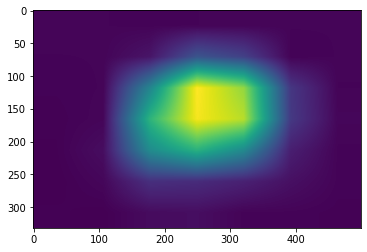

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
# cam이미지와 원본 이미지를 합치는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


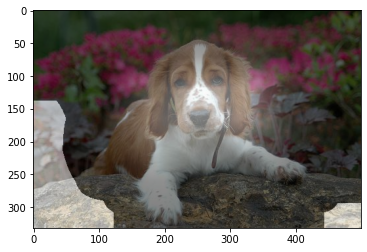

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착한다
- 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, 사람이 개를 식별할 때 유의해서 보는 부분과 같다



## 6-7. Grad-CAM
---
- Grad-CAM을 이용해서 CAM을 얻어보자
- 모델은 cam_model을 그대로 활용

108


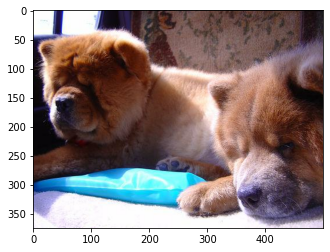

In [ ]:
# 새로운 이미지 가져오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- grad_cam 은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 gap연산을 적용해서 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
- 최종 cam이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해준다
- 이전스텝의 cam함수와는 달리 grad-cam은 어떤 레이어든 cam이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 해야함
- 아래 함수에서는 원하는 레이어의 output과 특정 클래스의 prediction사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


- 만든 함수로 여러 레이어의 cam이미지를 뽑아서 확인해보자
- 레이어 이름은 이전 스텝의 cam_model.summary()결과에서 찾을 수 있다

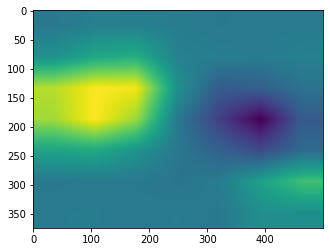

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

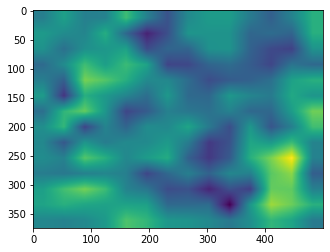

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

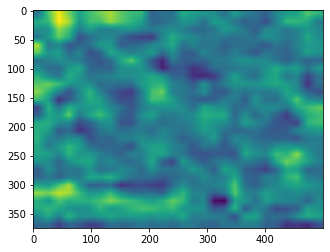

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 6-8. Detection with CAM
---
#### 바운딩 박스
- cam에서 물체의 위치를 찾는 detection을 해보자

40


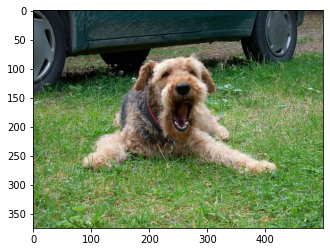

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

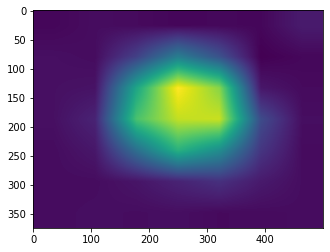

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- `get_bbox()` 
    - 바운딩 박스를 만들기 위해 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다
    - 그 다음 openCV의 findContours()랑 minAreaRect()로 사각형을 찾는다
    - 이 때 rotated_rect라는 회전된 바운딩 박스를 얻을 수 있다.
    - boxPoints()로 이것을 꼭지점으로 바꾼다
    - 마지막에는 int 자료형으로 변환

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [ ]:
rect = get_bbox(cam_image)
rect

array([[407, 352],
       [ 63, 262],
       [133,  -8],
       [477,  80]])

- cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화

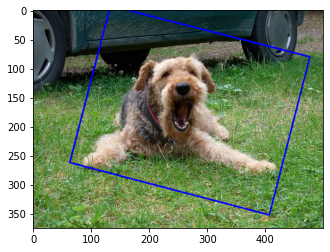

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### Intersection over union(IOU)
- cam이랑 grad-cam으로 얻은 바운딩 박스를 정답 데이터 바운딩 박스와 비교하는 방법
- 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union영역으로 나누어준 값
- 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있다
- 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다


In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [ ]:
# rect를 mimmax bbox형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.021333333333333333, 0.126, 0.9386666666666666, 0.954]

In [ ]:
# 이 데이터의 ground truth bbox를 확인
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

- cam 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷한가?
- IOU를 계산해서 유사도를 확인

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4787640661097187